We'll try a regression network this time. We'll be predicting housing prices

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


65536/57026 [==================================] - 0s 3us/step


Let's look at the data

In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

It's very little data compared to the other datasets we've looked at so far. Targets are in thousands of dollars

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

Because of the variance in the data, we'll do feature normalization by subtracting the man and dividing by std. deviations

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

# always normalize test data according to your training data. Never use test data for normalizing
test_data -= mean
test_data /= std

Let's build the network. We'll be using a function for that, because we'll be building several of them for k-folds

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()

    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # output layer, typical for scalar regression
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Now, lets do k-fold training

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #:', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

('processing fold #:', 0)
('processing fold #:', 1)
('processing fold #:', 2)
('processing fold #:', 3)


In [8]:
print(all_scores)

[2.1103371523394445, 2.1075122663290196, 2.8739126531204375, 2.453442376438934]


We can take the average of the scores and it gives you a good idea of how good the fit is. With 500 epochs let's see how it runs. We'll save the epoch validation score log as well.

In [9]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

('processing fold #', 0)
('processing fold #', 1)
('processing fold #', 2)
('processing fold #', 3)


Let's see the result

In [10]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
print(average_mae_history)

[4.796260101960437, 3.3882256663671813, 3.0612614095801174, 2.747644815114465, 2.799810482723878, 2.7023435807464145, 2.6392762318696126, 2.6321784812625095, 2.5623982200528137, 2.5918902182342984, 2.4918292855272197, 2.732686909118501, 2.514995798025981, 2.398953640815055, 2.431565924446182, 2.4221464891244873, 2.4789623871888264, 2.4452023175683353, 2.3615982261034523, 2.5021845149521784, 2.3844486947106844, 2.3553764584040877, 2.31786837908301, 2.3412853668231772, 2.5048914522227674, 2.333243751289821, 2.287246332310214, 2.4081007885460806, 2.3171139152923432, 2.4534663858980235, 2.3736788494752186, 2.496069152756493, 2.3486995059664886, 2.464325207294804, 2.4365226042152632, 2.283735151338105, 2.3914516786537545, 2.3333070915524323, 2.312938592221477, 2.3827563152454867, 2.270751727689611, 2.302550824561922, 2.3124740938148873, 2.3031059538964, 2.236624191303064, 2.4791088092445146, 2.287800084246267, 2.3528475371917876, 2.351112145008427, 2.320212314034453, 2.276922103201989, 2.30

Let's look at the MAE history by epochs

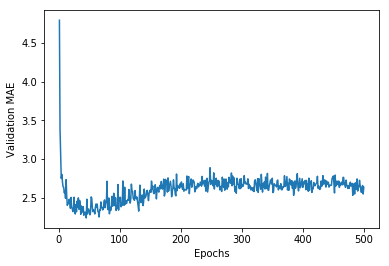

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Let's smooth it out and remove the first bits to get a better look at the data

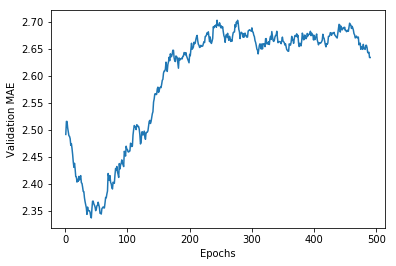

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Looks like after 80 epochs it starts overfitting. Let's train the final model. With little data, use k-fold validation, and small network with few hidden layers to avoid severe overfitting. For regression it's common to use MSE and MAE

In [13]:
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

102/102 [==============================] - 0s 679us/step
2.675027146058924
